# Predicting Credit Card Defaults

This notebook contains a lot of exploration and fine tuning I used to create the final analysis.

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
raw = pd.read_excel("data/default_of_credit_card_clients.xls")

In [10]:
raw.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [11]:
data = raw.copy()
data.columns = data.iloc[0, :]
data.drop("ID", axis=0, inplace=True)
data.columns = [x.lower() for x in data.columns]
data.rename(columns={"pay_0": "pay_1"}, inplace=True)
data = data.astype("float64")
data.head()

,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default payment next month
1,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
2,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1.0
3,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0.0
4,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0.0
5,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0.0


Create a stratified sampling function and verify that it works correctly.

In [12]:
#stratified sampling
def stratified_sample(n, data, column):
    defaults = data[data[column] == 1]
    non_defaults = data[data[column] == 0]
    frac1 = len(defaults.index) / (len(defaults.index) + len(non_defaults.index))
    frac2 = 1 - frac1
    count1 = int(np.ceil(n * frac1))
    count2 = int(np.floor(n * frac2))
    
    df1 = defaults.sample(n=count1, random_state=12)
    df2 = non_defaults.sample(n=count2, random_state=12)
    df = pd.concat((df1, df2)).sample(frac=1, random_state=12)
    df.index = list(range(0, len(df.index)))
    return df

sampled_data = stratified_sample(500, data, "default payment next month")
print(sampled_data["default payment next month"].value_counts() / len(sampled_data.index))
print(data["default payment next month"].value_counts() / len(data.index))

0.0    0.778
1.0    0.222
Name: default payment next month, dtype: float64
0.0    0.7788
1.0    0.2212
Name: default payment next month, dtype: float64


Weak correlation between payment delays within consecutive months. Peaks around a payment delay of around 2-3 months.

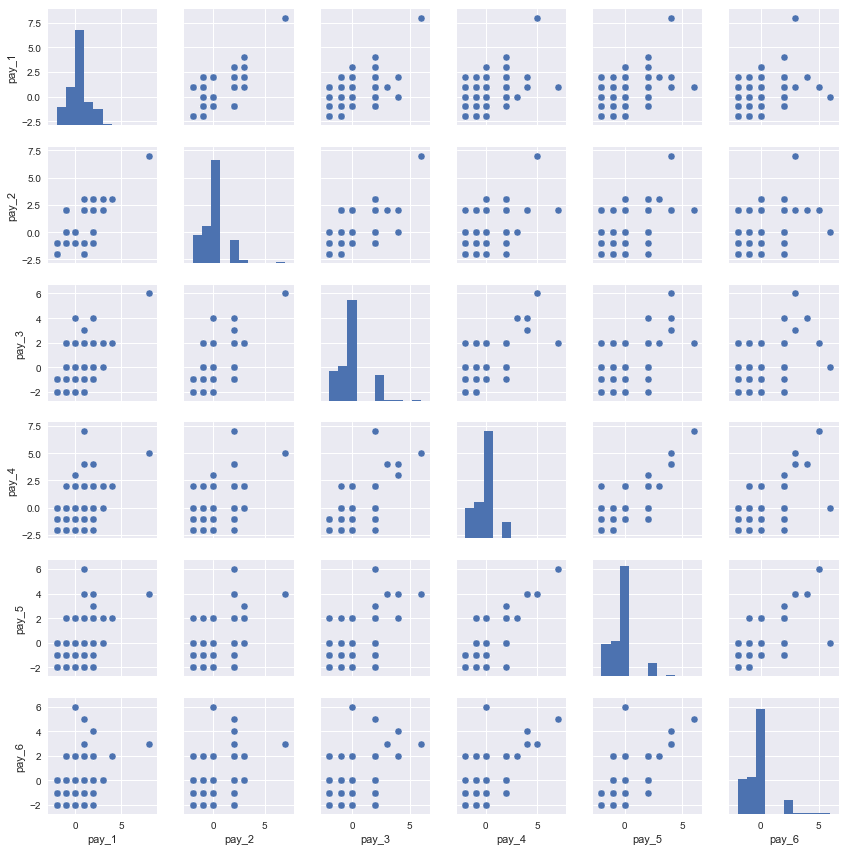

In [13]:
repayment_status = sampled_data.iloc[:, 5:11]
sns.pairplot(repayment_status, size=2)
plt.show()

Data appears much more correlated. Significance is that monthly bill statements are likely to be similar, with the similarity decreasing as the gap between months grows.

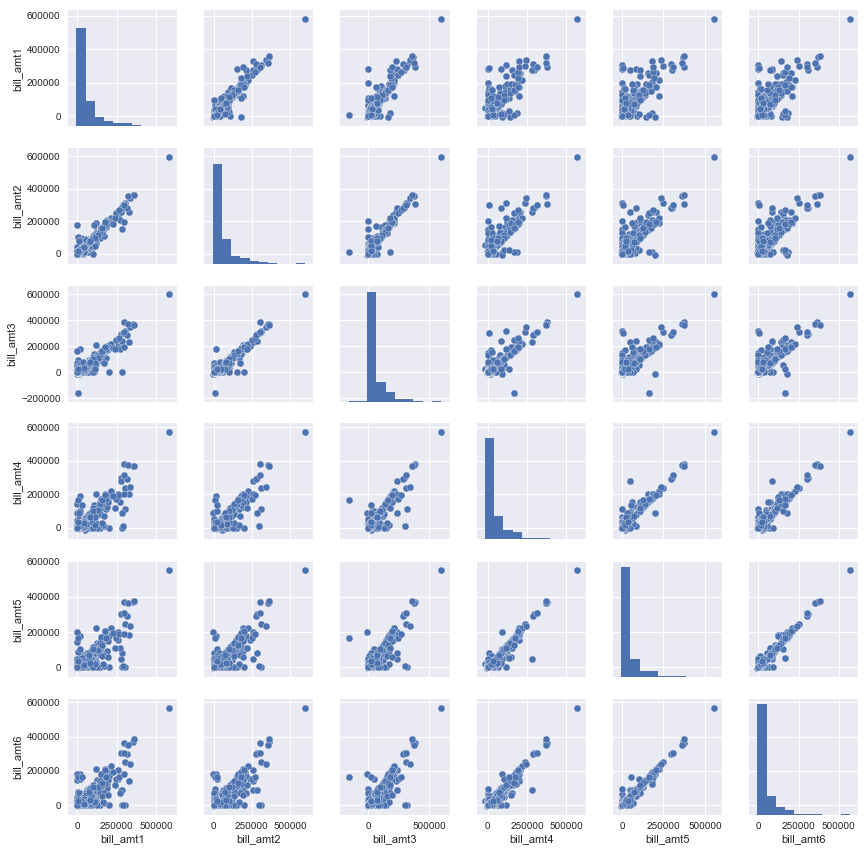

In [14]:
bill_statements = sampled_data.iloc[:, 11:17]
sns.pairplot(bill_statements, size=2)
plt.show()

Very skewed distrubtions. Most people owe little, but there are extreme outliers (could possibly indicate a default if the payment amount is too high to pay off).

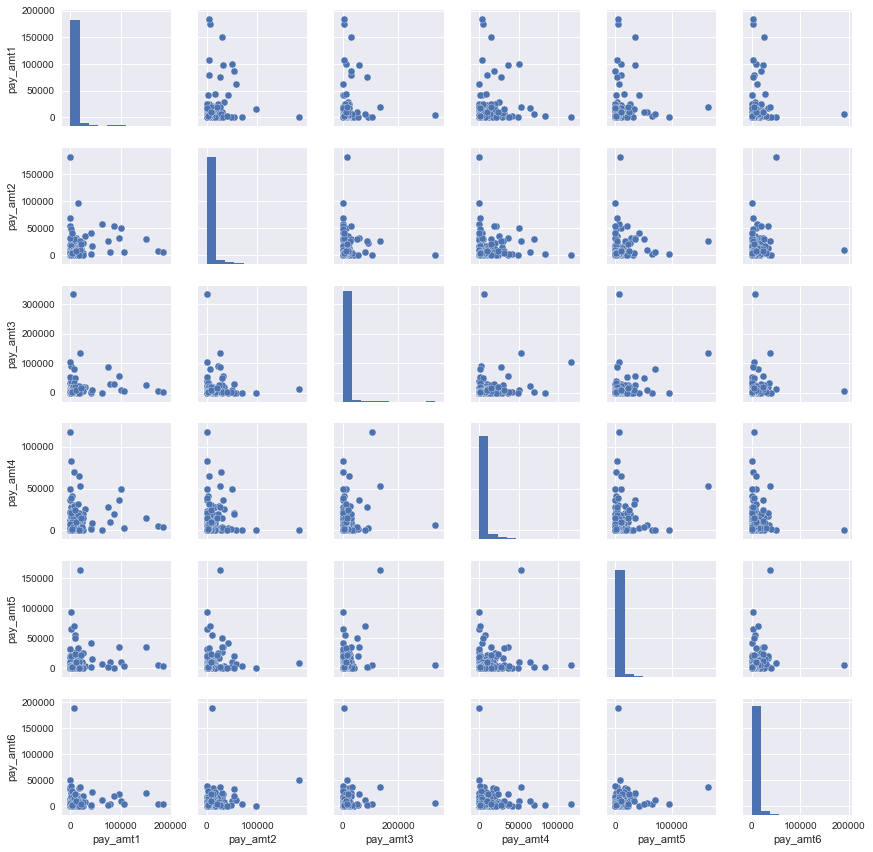

In [15]:
previous_payments = sampled_data.iloc[:, 17:23]
sns.pairplot(previous_payments, size=2)
plt.show()
#much more skewed than previous data.
#most people owe little, but a couple outliers

Sometimes fair correlation between the amounts of the previous payments and current bill statements.
Usually strong correlation between repayment status and bill amount, indicating that those who are past due owe a lot.
Interestingly, there is little correlation between repayment status and previous payments.

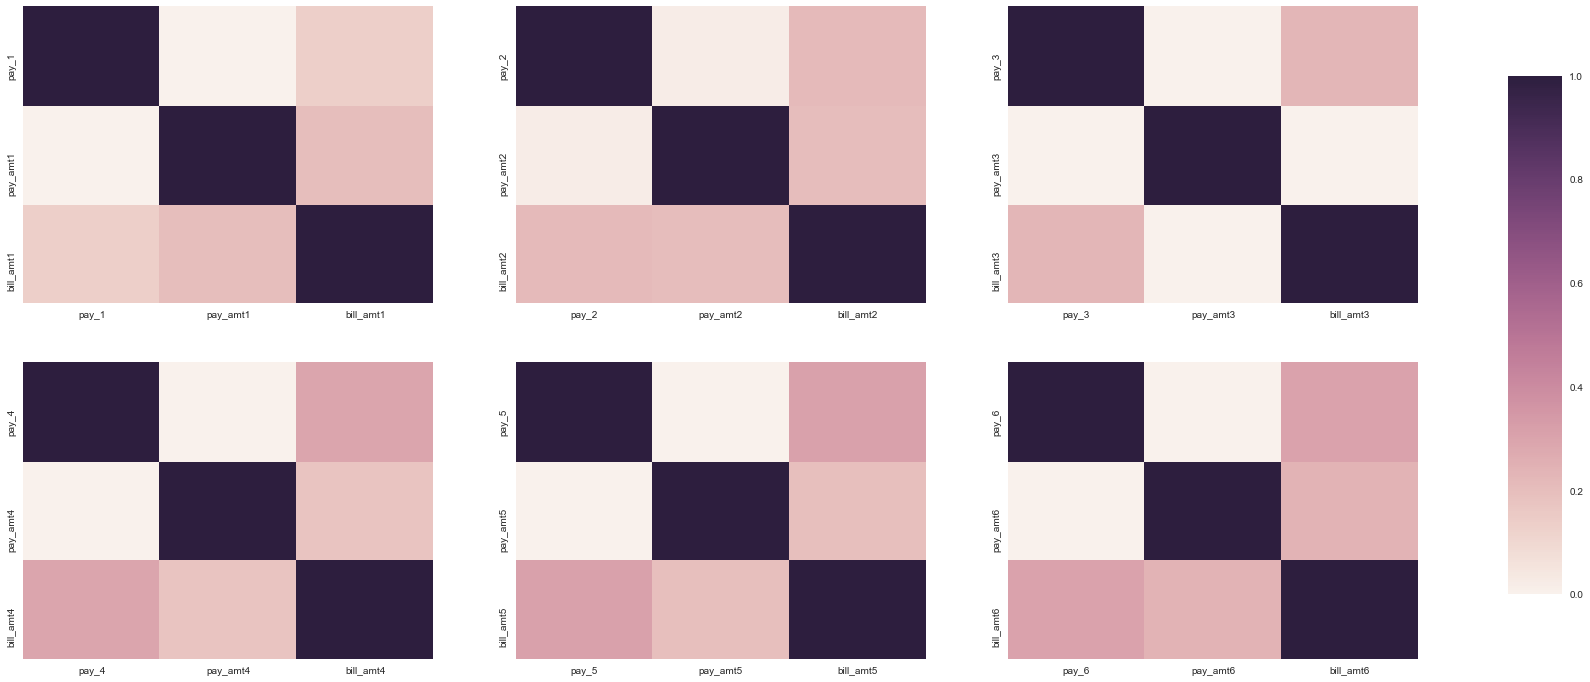

In [16]:
def heatmaps(x, y, z, n=6, dim1=2, dim2=3):
    fig, ax = plt.subplots(dim1, dim2, sharex=False, sharey=False, figsize=(25, 12))
    cbar_ax = fig.add_axes([.95, .2, .03, .6])
    sns.set(font_scale=1.2)
    
    for i, ax in enumerate(ax.flat):
        df = pd.concat((x.iloc[:, i], y.iloc[:, i], z.iloc[:, i]), axis=1)
        sns.heatmap(df.corr(), ax=ax, vmin = 0, vmax = 1, cbar = i == 0, cbar_ax=None if i else cbar_ax)
    
    plt.show()

heatmaps(repayment_status, previous_payments, bill_statements)

History of past payment has a large correllation. Everything else not so much. Indicates that the data is likely sparse. Two intial models will be trained: pca then a random forest/svm. ROC curve and accuracy will be used for analysis since outcomes are not extremely skewed.

In [17]:
data.corr()["default payment next month"].sort_values(ascending=False)

default payment next month    1.000000
pay_1                         0.324794
pay_2                         0.263551
pay_3                         0.235253
pay_4                         0.216614
pay_5                         0.204149
pay_6                         0.186866
education                     0.028006
age                           0.013890
bill_amt6                    -0.005372
bill_amt5                    -0.006760
bill_amt4                    -0.010156
bill_amt3                    -0.014076
bill_amt2                    -0.014193
bill_amt1                    -0.019644
marriage                     -0.024339
sex                          -0.039961
pay_amt6                     -0.053183
pay_amt5                     -0.055124
pay_amt3                     -0.056250
pay_amt4                     -0.056827
pay_amt2                     -0.058579
pay_amt1                     -0.072929
limit_bal                    -0.153520
Name: default payment next month, dtype: float64

In [18]:
numerical = data.loc[:, ["limit_bal","age", "bill_amt1", "bill_amt2", "bill_amt3", "bill_amt4", "bill_amt5", "bill_amt6",
                        "pay_amt1", "pay_amt2", "pay_amt3", "pay_amt4", "pay_amt5", "pay_amt6"]]
categorical = data.loc[:, ["sex", "education", "marriage", "pay_1", "pay_2",
                           "pay_3", "pay_4", "pay_5", "pay_6"]]
categorical = categorical + 2
y = data.loc[:, "default payment next month"]

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())])

cat_pipeline = Pipeline([
    ('label_binarizer', OneHotEncoder(n_values=12))
])

num_prepared = num_pipeline.fit_transform(numerical)
cat_prepared = cat_pipeline.fit_transform(categorical)
X = np.concatenate((num_prepared, cat_prepared.toarray()), axis=1)
print(X.shape)

(30000, 122)


New X_comp still has 21 columns, compared to 122 after one hot encoding, and still explains 95% of the variance in the data.

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components = .95)
X_comp = pca.fit_transform(X)
X_train_comp, X_val_comp, y_train, y_val = train_test_split(X_comp, y, test_size=0.2, random_state=12)
print(pca.explained_variance_ratio_)

[0.31882139 0.10497336 0.06491774 0.05291858 0.04650411 0.04553575
 0.04477607 0.04012747 0.03756452 0.0351983  0.03251049 0.02531637
 0.01967996 0.01718856 0.01531049 0.01317432 0.01158206 0.00907691
 0.00739884 0.00674478 0.00525962]


Bagging and pasting methods will be explored.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

#try both bagging and pasting methods
forest_params = [
{'n_estimators': [3, 10, 30], 'max_features': [6, "sqrt", "log2", None]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': ["sqrt", "log2", None]},
]

forest_class = RandomForestClassifier()
forest_grid = GridSearchCV(forest_class, forest_params, cv=5, scoring="neg_mean_squared_error")
forest_grid.fit(X_train_comp, y_train)

"'max_features': 'log2', 'num_estimators': 30"

"'max_features': 'log2', 'num_estimators': 30"

In [22]:
forest_grid.best_params_

{'max_features': 'sqrt', 'n_estimators': 30}

In [23]:
best_forest = RandomForestClassifier(max_features="log2", n_estimators=30)
best_forest.fit(X_train_comp, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [24]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

def plot_learning_curves(X, y, model, title=None, start=500, end=20000):
    X_train, X_val, y_train, y_val = train_test_split(X[start:end], y[start:end], test_size=0.2, random_state=12)    
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.001, 1, 20))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    if title:
        plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, marker='o', 
             markerfacecolor='red', markersize=8, color='red', linewidth=2, label="Training")
    plt.plot(train_sizes, test_scores_mean, marker='o', 
             markerfacecolor='blue', markersize=8, color='blue', linewidth=2, label="Cross-Validation")
    plt.legend(loc="best")
    plt.show()

Plot indicates severe overfitting.

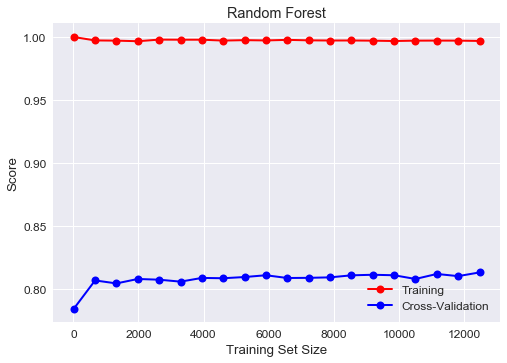

In [25]:
plot_learning_curves(X_train_comp, y_train, best_forest, title="Random Forest")

Helper function to explore how out-of-bag error changes as max_depth increases (regularization term).

In [26]:
def plot_oob_score(X, y, interval=list(range(1, 40)), n_estimators=100):
    varied_forest = RandomForestClassifier(warm_start=False, oob_score=True, 
                                           n_jobs=-1, max_features="auto", n_estimators=n_estimators)
    oob_errors=[]
    for i in interval:
        varied_forest.set_params(max_depth=i)
        varied_forest.fit(X, y)
        oob_errors.append(1 - varied_forest.oob_score_)
    plt.figure()
    plt.xlabel("max_depth")
    plt.plot(interval, oob_errors, 
             markerfacecolor='green', color='green', linewidth=2)
    plt.show()  

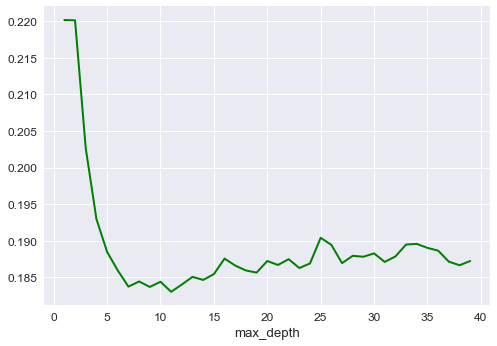

In [27]:
plot_oob_score(X_train_comp, y_train)

In [28]:
best_forest = RandomForestClassifier(max_features="sqrt", n_estimators=100, max_depth=10, random_state=12, n_jobs=-1)
best_forest.fit(X_train_comp, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=12,
            verbose=0, warm_start=False)

Both functions now appear to converge to one value.

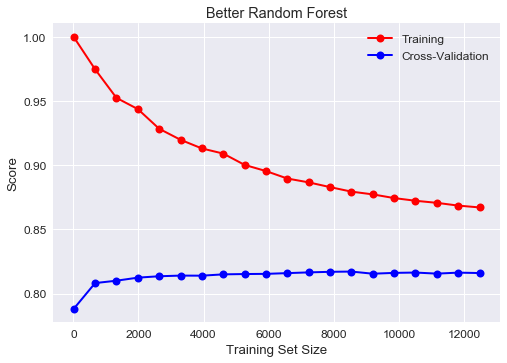

In [29]:
plot_learning_curves(X_train_comp, y_train, best_forest, title="Better Random Forest")

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

def eval_metrics(X_true, y_true, model):
    y_forest_proba = model.predict_proba(X_true)
    y_forest_pred = model.predict(X_true)
    fpr, tpr, thresholds = roc_curve(y_true, y_forest_proba[:, 1])
    print("Accuracy: " + str(accuracy_score(y_val, y_forest_pred)))
    print("AUC: " + str(roc_auc_score(y_true, y_forest_proba[:, 1], average="macro", sample_weight=None)))
    
def plot_ROC(X_true, y_true, model):
    y_forest_proba = model.predict_proba(X_true)
    fpr, tpr, thresholds = roc_curve(y_true, y_forest_proba[:, 1])
    plt.figure()
    plt.title("ROC")
    plt.xlabel("True Negative")
    plt.ylabel("True Positive")
    plt.plot(fpr, tpr, color="blue")
    plt.show()
    

Accuracy: 0.8156666666666667
AUC: 0.7720735011050118


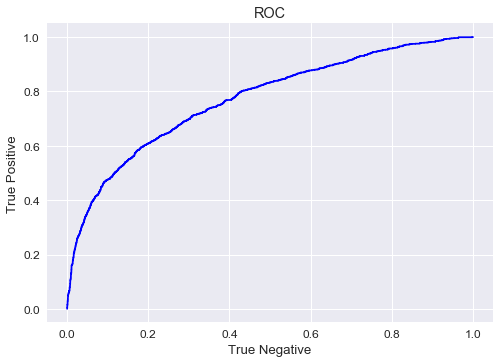

In [31]:
eval_metrics(X_val_comp, y_val, best_forest)
plot_ROC(X_val_comp, y_val, best_forest)

Cell below takes a VERY long time to run.

In [32]:
from sklearn.svm import SVC

svc_params = [{"C": [.1, 1, 10, 100], "gamma": ["auto", .1, .01, .001], "probability": [False], }]

svc_class = SVC()
svc_grid = GridSearchCV(svc_class, svc_params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
svc_grid.fit(X_train_comp, y_train)

"'C: 1, 'gamma': 'auto'"

"'C: 1, 'gamma': 'auto'"

In [33]:
svc_grid.best_params_

{'C': 1, 'gamma': 'auto', 'probability': False}

In [34]:
best_svc = SVC(C=1, gamma="auto", probability=True)
best_svc.fit(X_train_comp, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Fairly good plot, but does not converge to a score as high as the random forest and also appears less stable.

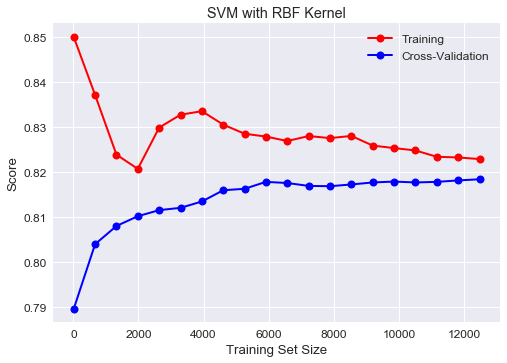

In [35]:
plot_learning_curves(X_train_comp, y_train, best_svc, title="SVM with RBF Kernel")
#looks like a good plot, but does not reach a score as high as the random forest.

Both methods performed similarly, but the random forest had a higher AUC by ~3% and a smaller accuracy by only ~0.2%.

Accuracy: 0.8175
AUC: 0.7422121654411391


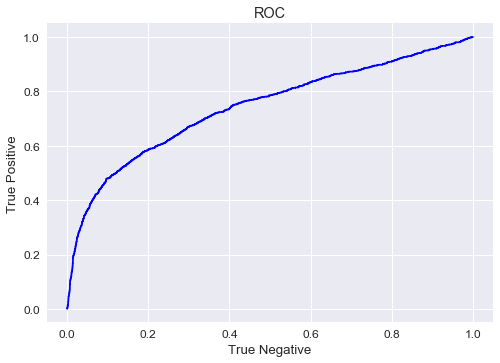

In [36]:
eval_metrics(X_val_comp, y_val, best_svc)
plot_ROC(X_val_comp, y_val, best_svc)
#both methods ended up performing similarly.

In [37]:
from sklearn.externals import joblib
joblib.dump(best_forest, "saves/model.pkl")
joblib.dump(pca, "saves/pca.pkl")
joblib.dump(num_pipeline, "saves/num_pipeline.pkl")
joblib.dump(cat_pipeline, "saves/cat_pipeline.pkl")
data.to_pickle("saves/cleaned_data.pkl")

Dataset found at: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients